# 1) Imports

In [1]:
# Bibliotecas padrão
import os                     # Manipulação de caminhos e arquivos
import locale                 # Para configuração de locale (ex.: formatação BRL)
import numpy as np            # Operações numéricas e vetoriais
import pandas as pd           # Manipulação e análise de dados em DataFrames

import matplotlib.pyplot as plt 
import seaborn as sns

# Configuração de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


# SCIKIT-LEARN — Modelos, validação e pré-processamento
from sklearn.model_selection import train_test_split, cross_val_score    # Divisão treino/teste e validação cruzada
from sklearn.compose import ColumnTransformer                            # Aplica transformações diferentes por coluna
from sklearn.pipeline import Pipeline                                    # Encadeia etapas (preprocessamento → modelo)
from sklearn.preprocessing import StandardScaler, OneHotEncoder          # Normalização e codificação categórica
from sklearn.metrics import (mean_absolute_error, r2_score, 
                             make_scorer, mean_squared_log_error)        # Métricas de avaliação
from sklearn.cluster import KMeans                                       # Agrupamento para criar clusters de bairros
from sklearn.linear_model import LinearRegression                        # Modelo linear de baseline
from sklearn.ensemble import RandomForestRegressor                       # Modelos baseados em árvores


# XGBOOST — Modelo gradient boosting avançado
from xgboost import XGBRegressor  # Um dos melhores modelos para dados tabulares


# CATEGORY ENCODERS — Codificadores avançados
from category_encoders import TargetEncoder  # Encoding baseado no target (bom para categorias com muitas classes)


# JOBLIB — Salvamento de modelos
import joblib  # Permite salvar pipelines/modelos treinados para uso posterior

# 2) Configurações e utilitários

In [2]:
DATA_PATH = '../Dados/imoveis_locacao_filtrado.csv' # Caminho do arquivo CSV contendo os dados dos imóveis.

MODEL_OUT = 'pipeline_final.joblib' # Nome do arquivo onde será salvo o pipeline final treinado (modelo + pré-processamento).

# RANDOM_STATE = 42  Garantir reprodutibilidade dos resultados.

# N_JOBS = -1 Número de núcleos da CPU utilizados em paralelização (-1 = usar todos disponíveis).


#  Configurar formatação numérica BR
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')          # Tenta configurar o locale para pt_BR para formatação de números e moedas.
pd.options.display.float_format = 'R$ {:,.2f}'.format   # Altera a formatação padrão de floats do pandas para exibir como valores monetários BR.


#  Métrica RMSLE (Root Mean Squared Logarithmic Error)
def rmsle(y_true, y_pred):
    """
    Calcula RMSLE garantindo que os valores negativos sejam truncados para zero.
    Isso evita erros de logaritmo negativos.
    RMSLE é útil quando queremos punir proporcionalmente erros relativos.
    """

    # Evita valores negativos antes de aplicar o log
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)

    return np.sqrt(mean_squared_log_error(y_true, y_pred))


# Scorer do scikit-learn para usar o RMSLE em validação cruzada.
rmsle_scorer = make_scorer(lambda y_true, y_pred: -rmsle(y_true, y_pred)) # O scikit-learn maximiza scores, então colocamos sinal negativo.


#  Função auxiliar para imprimir resultados formatados
def print_results(df_results: pd.DataFrame):
    """
    Exibe uma tabela de resultados (DF) formatada.
    Caso existam colunas de valores monetários ou métricas,
    elas são formatadas para melhorar a leitura.
    """
    if 'MAE (R$)' in df_results.columns:
        print(
            df_results.to_string(
                formatters={
                    'MAE (R$)': 'R$ {:,.2f}'.format,
                    'R²': '{:.3f}'.format
                },
                index=False
            )
        )
    else:
        print(df_results)

# 3) Carregar dados

In [3]:
print("Carregando dados de:", DATA_PATH) # Exibe o caminho do arquivo que será carregado

try:
    # Tenta carregar o arquivo CSV contendo os dados dos imóveis
    df = pd.read_csv(DATA_PATH)

    # Confirma que o carregamento foi bem-sucedido e mostra o número total de linhas
    print("Dados carregados com sucesso. Linhas:", len(df))

except FileNotFoundError:
    # Caso o arquivo não exista no caminho especificado, lança um erro mais claro
    raise FileNotFoundError(f"Arquivo não encontrado: {DATA_PATH}")


print(df.head()) # Mostra as primeiras linhas do dataframe para uma visão rápida das colunas e estrutura

print(df.info()) # Exibe informações gerais: tipos de dados, quantidade de valores não nulos e uso de memória

Carregando dados de: ../Dados/imoveis_locacao_filtrado.csv
Dados carregados com sucesso. Linhas: 853
          tipo                  bairro     cidade objetivo  area_util  \
0         casa          americanopolis  são paulo  Locação   R$ 40.00   
1         casa         vila_gumercindo  são paulo  Locação   R$ 25.00   
2         casa         vila_gumercindo  são paulo  Locação   R$ 25.00   
3         casa            vila_fachini  são paulo  Locação   R$ 50.00   
4  apartamento  jardim_miriam_zona_sul  são paulo  Locação   R$ 30.00   

   quartos  suites  vagas     preco  
0        1       0      0 R$ 800.00  
1        1       0      0 R$ 850.00  
2        1       0      0 R$ 850.00  
3        1       0      0 R$ 850.00  
4        1       0      0 R$ 850.00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tipo       853 non-null    object 
 1   bai

# 4) Limpeza e engenharia básica de features

### 4.1 Features novas

In [4]:
# Cria variável binária indicando se o imóvel possui ao menos 1 suíte
df['tem_suite'] = (df['suites'] > 0).astype(int)

# Cria variável binária indicando se o imóvel possui vaga de garagem
df['tem_vaga'] = (df['vagas'] > 0).astype(int)

# Calcula quantos metros quadrados há por quarto
# Quando quartos = 0, substituímos por NaN para evitar divisão por zero
df['area_por_quarto'] = df['area_util'] / df['quartos'].replace(0, np.nan)

# Para imóveis sem quartos, usamos a própria área do imóvel como fallback
df['area_por_quarto'] = df['area_por_quarto'].fillna(df['area_util'])

# Calcula a proporção de suítes por quarto (medida de "sofisticação")
# Divide por quartos substituindo 0 por NaN para não estourar
df['proporcao_suites'] = df['suites'] / df['quartos'].replace(0, np.nan)

# Imóveis com 0 quartos ou onde a divisão não faz sentido recebem valor 0
df['proporcao_suites'] = df['proporcao_suites'].fillna(0)

# Aplica transformação logarítmica ao preço (log1p evita problemas com valores 0)
# Melhora distribuição, reduz efeito de outliers e ajuda modelos a convergir melhor
df['preco_log'] = np.log1p(df['preco'])

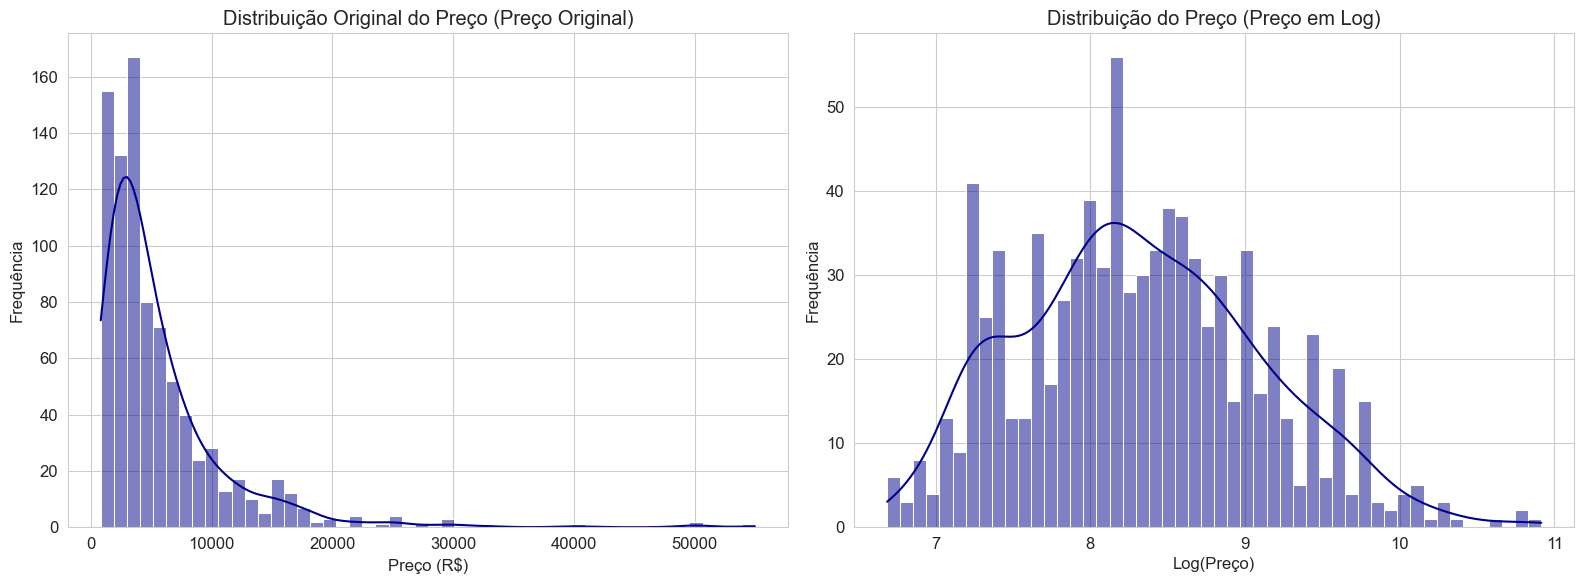

In [5]:
# --- Gráfico 1: Comparação Preço Original vs. Log ---
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico da esquerda: Preço Original
sns.histplot(df['preco'], bins=50, kde=True, ax=ax[0], color='darkblue')
ax[0].set_title('Distribuição Original do Preço (Preço Original)')
ax[0].set_xlabel('Preço (R$)')
ax[0].set_ylabel('Frequência')

# Gráfico da direita: Preço em Log
sns.histplot(df['preco_log'], bins=50, kde=True, ax=ax[1], color='darkblue')
ax[1].set_title('Distribuição do Preço (Preço em Log)')
ax[1].set_xlabel('Log(Preço)')
ax[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

### 4.2 Binning para stratify na divisão treino/teste

In [6]:
"""
Criar a variável preco_bin para representar faixas de preço.
Isso pode ajudar alguns modelos a capturar padrões não lineares.
Usar qcut porque ele divide os dados em quantis — criando bins com
quantidade de amostras aproximadamente igual em cada faixa.
"""
try:
    df['preco_bin'] = pd.qcut(df['preco'], q=10, duplicates='drop', labels=False)
except Exception:
    """
    Caso qcut falhe (por valores duplicados ou distribuição estranha),
    usamos cut com intervalos fixos, que cria bins de mesmo tamanho em valor,
    mas não necessariamente com o mesmo número de amostras.
    """
    df['preco_bin'] = pd.cut(df['preco'], bins=10, labels=False)

# Visualização rápida das novas features para ver se estão dentro do esperado
print('Feature engineering concluída. Exemplo:')
print(df[['preco', 'preco_log', 'area_util', 'area_por_quarto']].describe())

Feature engineering concluída. Exemplo:
             preco  preco_log  area_util  area_por_quarto
count    R$ 853.00  R$ 853.00  R$ 853.00        R$ 853.00
mean   R$ 5,673.15    R$ 8.32  R$ 126.19         R$ 50.61
std    R$ 5,575.40    R$ 0.78  R$ 111.32         R$ 28.51
min      R$ 800.00    R$ 6.69   R$ 15.00         R$ 15.00
25%    R$ 2,400.00    R$ 7.78   R$ 49.00         R$ 33.33
50%    R$ 3,900.00    R$ 8.27   R$ 85.00         R$ 44.00
75%    R$ 6,930.00    R$ 8.84  R$ 165.00         R$ 60.00
max   R$ 55,000.00   R$ 10.92  R$ 900.00        R$ 275.00


# 5) Definir X, y e dividir treino/teste

In [7]:
# Lista de features numéricas, incluindo atributos originais e novas variáveis criadas (feature engineering)
# Elas ajudam o modelo a capturar melhor o tamanho, composição e proporções do imóvel.
features_numericas = [
    'area_util', 'quartos', 'suites', 'vagas',
    'tem_suite', 'tem_vaga',                  # variáveis binárias indicando presença de suíte e vaga
    'area_por_quarto', 'proporcao_suites'     # proporções que ajudam a medir qualidade dos cômodos
]

# Variáveis categóricas com poucas categorias -> serão codificadas com One-Hot Encoding
categorical_low = ['tipo', 'cidade']

# Variável categórica com muitas categorias -> será tratada via target encoding
categorical_high = ['bairro']

# Conjunto total de features categóricas
features_categoricas = categorical_low + categorical_high


# Define X (features) e y (target transformado em log)
X = df[features_numericas + features_categoricas]
y = df['preco_log']


# Split train/test:
# - 80% treino, 20% teste
# - estratificação por preco_bin para manter a distribuição de faixas de preço
# - também retornamos os índices originais, úteis para juntar resultados depois
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, df.index,
    test_size=0.2,
    random_state=42,
    stratify=df['preco_bin']
)

print(f"Split concluído. Treino: {len(X_train)}, Teste: {len(X_test)}")

Split concluído. Treino: 682, Teste: 171


# 6) Pré-processamento e pipelines

In [8]:
# PRÉ-PROCESSAMENTO — Two modes:
# A) OneHot completo
# B) OneHot (tipo, objetivo, cidade) + Target Encoding em bairro
#
# A ideia é permitir comparar duas estratégias diferentes de tratamento 
# das variáveis categóricas:
#   - OneHot: funciona bem quando as categorias não são muitas
#   - Target Encoding: melhor para categorias com muitos valores distintos (ex: bairros)


STRATEGIA_CATEGORICA = "onehot"  
# opções:
# "onehot" → One-hot em TODAS as categorias
# "target" → One-hot para categorias simples + Target Encoding para bairro


# Listas de variáveis por tipo
# categorias de baixa cardinalidade = poucas categorias → OneHot funciona bem
categoricas_baixa_card = ['tipo', 'cidade']

# variável de alta cardinalidade = MUITOS bairros diferentes → pode gerar sparse demais se usar OneHot
categoria_alta_card = ['bairro']

# variáveis numéricas (já definidas anteriormente no código)
numericas = features_numericas


# Pipeline 1 — One-Hot completo
if STRATEGIA_CATEGORICA == "onehot":
    preprocessor = ColumnTransformer(
        transformers=[
            # Normalização para variáveis numéricas
            ('num', StandardScaler(), numericas),

            # OneHotEncoder para todas as categorias, incluindo bairro
            # handle_unknown='ignore' evita erros com categorias novas no futuro
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
             categoricas_baixa_card + categoria_alta_card)
        ],
        remainder='drop'
    )


# Pipeline 2 — Target Encoding para bairros
elif STRATEGIA_CATEGORICA == "target":
    
    # Pipeline simples para OneHot
    onehot_pipe = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Pipeline para TargetEncoding
    # smoothing controla o "peso" da média global para evitar overfitting
    target_pipe = Pipeline([
        ('target', TargetEncoder(smoothing=0.3)) 
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            # Normalização das numéricas
            ('num', StandardScaler(), numericas),

            # OneHot apenas nas categorias pequenas
            ('onehot_low_card', onehot_pipe, categoricas_baixa_card),

            # Target Encoding apenas para bairro
            # (reduz sparsidade e ajuda modelos com poucos dados)
            ('target_bairro', target_pipe, categoria_alta_card)
        ],
        remainder='drop'
    )

else:
    raise ValueError("STRATEGIA_CATEGORICA deve ser 'onehot' ou 'target'.")

print("Pré-processamento configurado com estratégia:", STRATEGIA_CATEGORICA)

Pré-processamento configurado com estratégia: onehot


# 7) Funções auxiliares para treino/avaliação

In [9]:
def avaliar_pipeline(pipeline: Pipeline, X_train, y_train, X_test, y_test, tag: str = None):
    """Treina, prediz e retorna métricas em escala original (R$)."""
    
    # Treina o pipeline completo (pré-processamento + modelo)
    pipeline.fit(X_train, y_train)

    # Predições em escala log (porque treinamos com log(preço))
    y_pred_log = pipeline.predict(X_test)

    # Converte as previsões de volta para a escala original (R$)
    y_pred = np.expm1(y_pred_log)
    # Também converte o y_test (que está em log) para escala original
    y_true = np.expm1(y_test)

    # Calcula MAE em reais — métrica mais intuitiva
    mae = mean_absolute_error(y_true, y_pred)

    # R² na escala original, indicando o quanto o modelo explica da variância dos preços
    r2 = r2_score(y_true, y_pred)

    # RMSLE — útil para comparar erros relativos em preços
    rmsle_val = rmsle(y_true, y_pred)

    # Retorna métricas + previsões para análises posteriores
    return {'Modelo': tag or 'modelo', 'MAE (R$)': mae, 'R²': r2, 'RMSLE': rmsle_val, 'pred': y_pred}


# Cross-validation usando MAE em log-scale (mais estável do que MAE direto em R$)
def cross_val_mae_log(estimator, X, y, cv=5):
    # Usa MAE (log) negativo porque cross_val_score maximiza a métrica
    scores = cross_val_score(estimator, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    # Retorna a média positiva e o desvio padrão dos folds
    return -np.mean(scores), np.std(scores)


# 8) Modelos base (pipelines completos)

In [10]:
# Dicionário para armazenar os modelos
models = {}

# 1. Regressão Linear
models['Regressão Linear'] = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# 2. Random Forest Regressor
models['Random Forest'] = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

# 3. XGBoost Regressor
models['XGBoost'] = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=200,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

# Avaliação com validação cruzada
print('\n--- Validação Cruzada (MAE em log-scale + R²) ---')

for name, pipe in models.items():
    
    # MAE em log
    mae_log_mean, mae_log_std = cross_val_mae_log(pipe, X_train, y_train, cv=5)
    
    # R² em escala normal
    r2_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
    r2_mean = r2_scores.mean()
    r2_std = r2_scores.std()
    
    print(f"{name}:")
    print(f"   MAE médio (log) = {mae_log_mean:.4f} (+/- {mae_log_std:.4f})")
    print(f"   R²              = {r2_mean:.4f} (+/- {r2_std:.4f})\n")



--- Validação Cruzada (MAE em log-scale + R²) ---
Regressão Linear:
   MAE médio (log) = 0.2726 (+/- 0.0299)
   R²              = 0.7837 (+/- 0.0161)

Random Forest:
   MAE médio (log) = 0.2814 (+/- 0.0326)
   R²              = 0.7682 (+/- 0.0262)

XGBoost:
   MAE médio (log) = 0.2874 (+/- 0.0329)
   R²              = 0.7564 (+/- 0.0362)



# 9) Treinar modelos base e avaliar em escala original

In [11]:
# Lista para guardar os resultados de cada modelo
results = []

# Loop pelos modelos/pipelines definidos anteriormente
for name, pipe in models.items():

    # Avalia o pipeline usando a função personalizada (treino + teste)
    # Retorna métricas como MAE, RMSE, R² e previsões
    out = avaliar_pipeline(pipe, X_train, y_train, X_test, y_test, tag=name)

    # Guarda apenas as métricas (remove 'pred', que contém as previsões)
    results.append({k: v for k, v in out.items() if k != 'pred'})


# Converte os resultados em DataFrame para organizar e comparar
df_results = pd.DataFrame(results).sort_values('MAE (R$)')

print('\n--- Resultados Teste (Base) ---')

# Função auxiliar que imprime o DataFrame com formatação amigável
print_results(df_results)


--- Resultados Teste (Base) ---
          Modelo    MAE (R$)    R²   RMSLE
Regressão Linear R$ 1,326.14 0.732 R$ 0.31
         XGBoost R$ 1,670.21 0.621 R$ 0.36
   Random Forest R$ 1,724.46 0.516 R$ 0.36


# 10) Agrupar categorias raras (especialmente bairros)

In [12]:
# Mostra quantos registros existem em cada bairro (importante para identificar categorias muito raras)
print(df.bairro.value_counts())

def reduzir_categorias_raras(df, coluna, minimo=2):
    """
    Agrupa categorias raras em 'outros'.

    - Bairros com poucos registros criam sparsidade no One-Hot Encoding
    - Isso prejudica modelos lineares e aumenta o risco de overfitting
    - Agrupar categorias raras melhora a estabilidade do modelo

    Parâmetros:
    - coluna: nome da coluna categórica
    - minimo: número mínimo de ocorrências para manter a categoria
    """
    contagem = df[coluna].value_counts()
    
    # Mantém apenas as categorias que aparecem pelo menos 'minimo' vezes
    categorias_validas = contagem[contagem >= minimo].index

    # Substitui categorias raras por "outros"
    df[coluna] = df[coluna].apply(lambda x: x if x in categorias_validas else "outros")
    return df

# Padroniza o nome dos bairros: minúsculas e sem espaços extras
df["bairro"] = df["bairro"].str.lower().str.strip()

# Aplica a redução de categorias (agrupa bairros muito raros em "outros")
df = reduzir_categorias_raras(df, "bairro", minimo=2)

# Mostra quantas categorias sobraram após o agrupamento
print("Categorias restantes em 'bairro':", df["bairro"].nunique())
print(df.bairro.value_counts())


bairro
saude                    80
indianopolis             43
vila_do_encontro         40
vila_guarani_zona_sul    31
vila_mariana             30
                         ..
real_parque               1
brooklin_novo             1
paineiras_do_morumbi      1
brooklin                  1
jardim_cordeiro           1
Name: count, Length: 113, dtype: int64
Categorias restantes em 'bairro': 83
bairro
saude                    80
indianopolis             43
vila_do_encontro         40
outros                   31
vila_guarani_zona_sul    31
                         ..
vila_gertrudes            2
sumarezinho               2
parque_colonial           2
granja_julieta            2
jardim_europa             2
Name: count, Length: 83, dtype: int64


# 11) Feature Engineering: Interações e novas variáveis

In [13]:
# Cria uma feature de interação entre área e quantidade de quartos.
# Captura imóveis "maiores e com muitos quartos", que tendem a ser mais valorizados.
df["quartos_area"] = df["quartos"] * df["area_util"]

# Cria interação entre vagas e área, indicando imóveis grandes com várias vagas.
df["vagas_area"] = df["vagas"] * df["area_util"]

# Mede quão "espaçosos" são os quartos em média.
df["densidade_quartos"] = df["area_util"] / (df["quartos"] + 0.1) # Usa +0.1 para evitar divisão por zero quando não há quartos.

# Razão de suítes por quarto, indicando sofisticação/luxo do imóvel.
df["suites_ratio"] = df["suites"] / (df["quartos"] + 0.1) # Usa +0.1 para evitar divisão por zero quando não há quartos.

# 12) Estatísticas por bairro (mean encoding simples)

In [14]:
# Média histórica do bairro
# Calcular o preço médio de locação para cada bairro usando toda a base de dados.
# Isso cria uma referência do "nível de preço" típico de cada região.
media_bairro = df.groupby("bairro")["preco"].mean()
df["preco_medio_bairro"] = df["bairro"].map(media_bairro)

# Desvio do preço do bairro
# Esta variável mede o quanto o preço do imóvel está acima ou abaixo da média do bairro.
# Serve para capturar anomalias e destacar imóveis muito baratos ou muito caros dentro da sua região.
df["dif_media_bairro"] = df["preco"] - df["preco_medio_bairro"]

# 13) Clusterização de bairros por média de preço

In [15]:
# Criar um dataframe temporário apenas com a média de preço por bairro
# Isso reduz variabilidade e permite agrupar bairros por perfil de valor
df_temp = media_bairro.reset_index()
df_temp.columns = ["bairro", "media_preco"]

# Aplicar KMeans para agrupar bairros em 5 clusters baseados na média de preço
# Assim, bairros com valores semelhantes ficam no mesmo grupo
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_temp["cluster_bairro"] = kmeans.fit_predict(df_temp[["media_preco"]])

# Criar um dicionário {bairro -> cluster}
# Depois mapear esses clusters de volta para o dataframe principal
map_clusters = df_temp.set_index("bairro")["cluster_bairro"].to_dict()
df["cluster_bairro"] = df["bairro"].map(map_clusters)


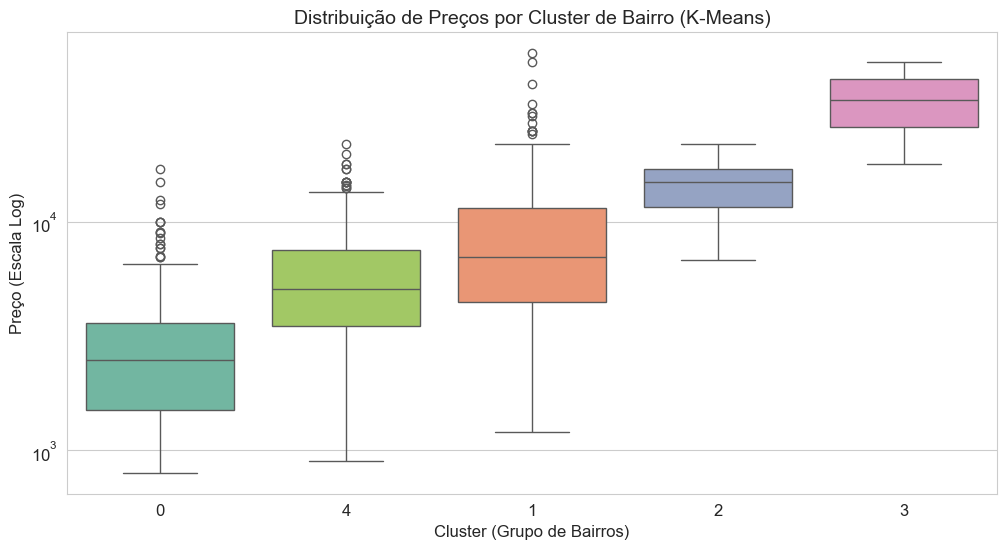

In [16]:
# --- Gráfico 2: Validação dos Clusters de Bairro ---
plt.figure(figsize=(12, 6))

# Ordena os clusters pela mediana de preço
order_clusters = df.groupby('cluster_bairro')['preco'].median().sort_values().index

# CORREÇÃO: Adicionado hue='cluster_bairro' e legend=False
sns.boxplot(
    x='cluster_bairro', 
    y='preco', 
    hue='cluster_bairro',
    data=df, 
    order=order_clusters, 
    palette='Set2', 
    legend=False          
)

plt.yscale('log') 
plt.title('Distribuição de Preços por Cluster de Bairro (K-Means)', fontsize=14)
plt.xlabel('Cluster (Grupo de Bairros)')
plt.ylabel('Preço (Escala Log)')
plt.show()

# 14) Atualizar a lista de features (inclui cluster e estatísticas)

In [17]:
# Definição das variáveis categóricas:
# - categorical_low: categorias com poucas variações → podem usar OneHot sem explodir colunas
# - categorical_high: categorias com muitas variações (ex.: bairros) → tratadas separadamente
categorical_low = ['tipo', 'cidade']
categorical_high = ['bairro']
features_categoricas = categorical_low + categorical_high

# Lista de variáveis numéricas:
# Inclui tanto atributos originais quanto variáveis derivadas (feature engineering)
# criadas para capturar relações não lineares e padrões específicos dos bairros.
features_numericas = [
    'area_util', 'quartos', 'suites', 'vagas',                     # atributos originais
    'quartos_area', 'vagas_area', 'densidade_quartos', 'suites_ratio',  # interações e razões
    'preco_medio_bairro', 'dif_media_bairro', 'cluster_bairro'     # informações derivadas por bairro
]

# Conjunto final de features X e variável alvo (log do preço)
X = df[features_numericas + features_categoricas]
y = df['preco_log']

# Divisão treino/teste:
# - Mantém 20% para teste
# - Usa stratify com preco_bin para garantir distribuição equilibrada dos preços
# - Retorna também os índices originais (train_idx, test_idx) para facilitar análises posteriores
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42, stratify=df['preco_bin']
)

# 15) Recriar ColumnTransformer

In [18]:
# -------------------------------------------------------------------------
# ColumnTransformer: responsável por aplicar transformações diferentes 
# para cada grupo de colunas antes de enviar os dados ao modelo.
#
# - "cat_low": categorias com poucas variações (tipo, cidade, objetivo)
#              -> recebem OneHotEncoder (gera colunas binárias estáveis)
#
# - "cat_high": categorias com muitas variações (bairro)
#               -> também recebem OneHotEncoder, MAS o agrupamento prévio
#                 dos bairros raros reduz sparsidade e melhora desempenho
#
# - "num": atributos numéricos (área, quartos, suites, vagas, features criadas)
#          -> recebem StandardScaler para colocar tudo na mesma escala
#
# O ColumnTransformer garante:
#    preprocessamento consistente
#    integração com o pipeline de ML
#    evita vazamento de dados (fit só no treino)
# -------------------------------------------------------------------------
col_transformer = ColumnTransformer(
    transformers=[
        ("cat_low", OneHotEncoder(handle_unknown='ignore'), categorical_low),
        ("cat_high", OneHotEncoder(handle_unknown='ignore'), categorical_high),
        ("num", StandardScaler(), features_numericas),
    ],
    remainder="drop"
)


# 16) Redefinir os modelos

In [19]:
# MODELOS UTILIZADOS
#
# Aqui definimos os modelos de machine learning que serão
# treinados com os dados transformados pelo pipeline.
#
# RandomForest:
#   - Modelo baseado em várias árvores de decisão.
#   - Funciona bem com dados tabulares.
#   - Captura relações não lineares.
#   - Não exige muita normalização dos dados.
#
# XGBoost:
#   - Gradient Boosting avançado e muito eficiente.
#   - Excelente para dados tabulares com features não lineares.
#   - Geralmente apresenta o melhor desempenho em modelos de preço.
#   - Usa a perda "reg:squarederror" para regressão.
#   - eval_metric="mae" faz o treino otimizar erro absoluto,
#     o que combina melhor com avaliações em log.
#
# Ambos recebem random_state para garantir reprodutibilidade.

models = {
    "RandomForest": RandomForestRegressor(random_state=42),

    "XGBoost": XGBRegressor(
        objective="reg:squarederror",   # função de perda para regressão
        eval_metric="mae",              # métrica usada durante treinamento
        random_state=42
    )
}

# 17) Hyperparameter Tuning

In [20]:
from sklearn.model_selection import RandomizedSearchCV

tuned_models = {}

# RANDOM FOREST — Busca de hiperparâmetros

# Aqui definimos um pequeno espaço de busca para o Random Forest.
# O objetivo é testar combinações diferentes de número de árvores,
# profundidade máxima e mínimo de amostras por split.
# O RandomizedSearchCV testa combinações aleatórias desses valores
# e encontra o conjunto que produz o menor erro MAE (em validação cruzada).

param_rf = {
    "n_estimators": [200, 400, 800],   # quantidade de árvores
    "max_depth": [None, 10, 20, 30],   # profundidade máxima da árvore
    "min_samples_split": [2, 5, 10],   # mínimo de amostras para dividir um nó
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_rf,
    n_iter=10,                          # número de combinações aleatórias testadas
    scoring="neg_mean_absolute_error",  # métrica: MAE negativo (quanto maior, melhor)
    cv=5,                               # validação cruzada com 5 folds
    n_jobs=-1,                          # usa todos os núcleos disponíveis
    random_state=42
)

# Treinamento do random search com os dados processados pelo ColumnTransformer
rf_search.fit(col_transformer.fit_transform(X_train), y_train)

# Armazena o melhor modelo encontrado
tuned_models["RandomForest"] = rf_search.best_estimator_



# XGBOOST — Busca de hiperparâmetros

# O XGBoost costuma ser o modelo mais forte em dados tabulares.
# Aqui testamos combinações de:
# - número de árvores (n_estimators)
# - taxa de aprendizado (learning_rate)
# - profundidade máxima das árvores (max_depth)
# - fração de amostra por árvore (subsample)

# O RandomizedSearchCV encontra os melhores parâmetros usando MAE.

param_xgb = {
    "n_estimators": [300, 600, 1000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.9, 1.0],
}

xgb_search = RandomizedSearchCV(
    XGBRegressor(
        objective="reg:squarederror",
        eval_metric="mae",
        random_state=42
    ),
    param_xgb,
    n_iter=10,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Treinamento do random search com dados transformados
xgb_search.fit(col_transformer.fit_transform(X_train), y_train)

# Armazena o melhor modelo encontrado
tuned_models["XGBoost"] = xgb_search.best_estimator_

# 18) Avaliar novamente com validação cruzada

In [21]:
print("\n--- Validação Cruzada Após Melhorias (MAE em log-scale) ---")

for name, model in tuned_models.items():

    # Criamos o pipeline combinando:
    # 1) o pré-processamento (one-hot, target encoding, scaling)
    # 2) o modelo regressivo ajustado (XGBoost ou RandomForest)
    pipe = Pipeline([
        ("preprocess", col_transformer),
        ("model", model)
    ])
    
    # Calcula o MAE médio em escala log usando validação cruzada (k=5).
    # Isso mede o erro percentual aproximado do modelo, que é mais estável
    # e menos sensível a outliers quando usamos log(preço).
    mae_log_mean, mae_log_std = cross_val_mae_log(pipe, X_train, y_train, cv=5)

    # Calcula também o R² via validação cruzada (k=5).
    # O R² mede o quanto o modelo explica da variabilidade dos preços.
    r2_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
    
    r2_mean = np.mean(r2_scores)
    r2_std = np.std(r2_scores)

    # Exibimos as métricas de forma clara para comparação entre modelos.
    print(f"{name}: MAE médio (log) = {mae_log_mean:.4f} (+/- {mae_log_std:.4f}) "
          f"e R² = {r2_mean:.4f} (+/- {r2_std:.4f})")


--- Validação Cruzada Após Melhorias (MAE em log-scale) ---
RandomForest: MAE médio (log) = 0.0868 (+/- 0.0135) e R² = 0.9697 (+/- 0.0083)
XGBoost: MAE médio (log) = 0.0639 (+/- 0.0078) e R² = 0.9811 (+/- 0.0065)


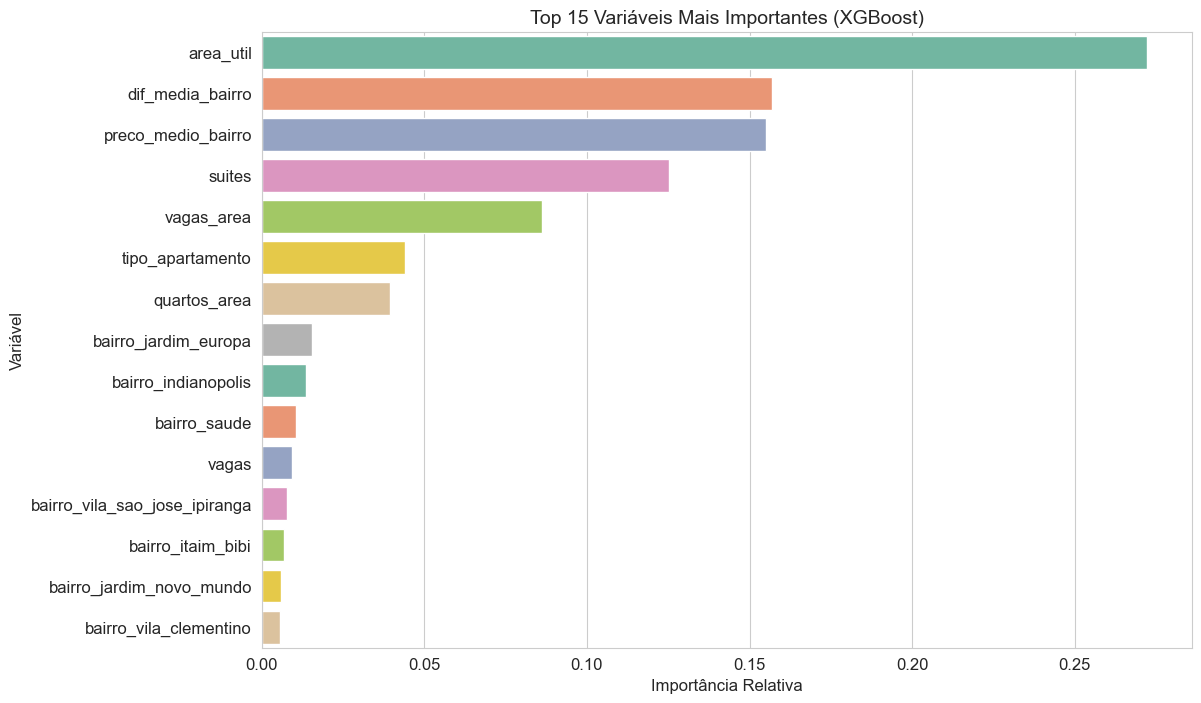

In [22]:
# --- Gráfico 3: Feature Importance (XGBoost) ---

# 1. Recuperar o melhor modelo e o transformador
best_model = tuned_models['XGBoost']
transformer = col_transformer

# 2. Recuperar nomes das features após o pré-processamento
feature_names = []

# Nomes das categorias
try:
    feature_names.extend(transformer.named_transformers_['cat_low'].get_feature_names_out())
    feature_names.extend(transformer.named_transformers_['cat_high'].get_feature_names_out())
except:
    pass

# Nomes das numéricas
feature_names.extend(features_numericas)

# 3. Pegar importâncias do modelo
importances = best_model.feature_importances_

# Garantir que temos o mesmo número de nomes e importâncias
if len(feature_names) == len(importances):
    # Criar DataFrame para plotar
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df_imp = df_imp.sort_values('Importance', ascending=False).head(15) # Top 15

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        hue='Feature',
        data=df_imp, 
        palette='Set2', 
        legend=False
    )
    plt.title('Top 15 Variáveis Mais Importantes (XGBoost)', fontsize=14)
    plt.xlabel('Importância Relativa')
    plt.ylabel('Variável')
    plt.show()
else:
    print("Não foi possível alinhar os nomes das features automaticamente.")

    plt.bar(range(len(importances)), importances)
    plt.title("Feature Importance (por índice)")
    plt.show()

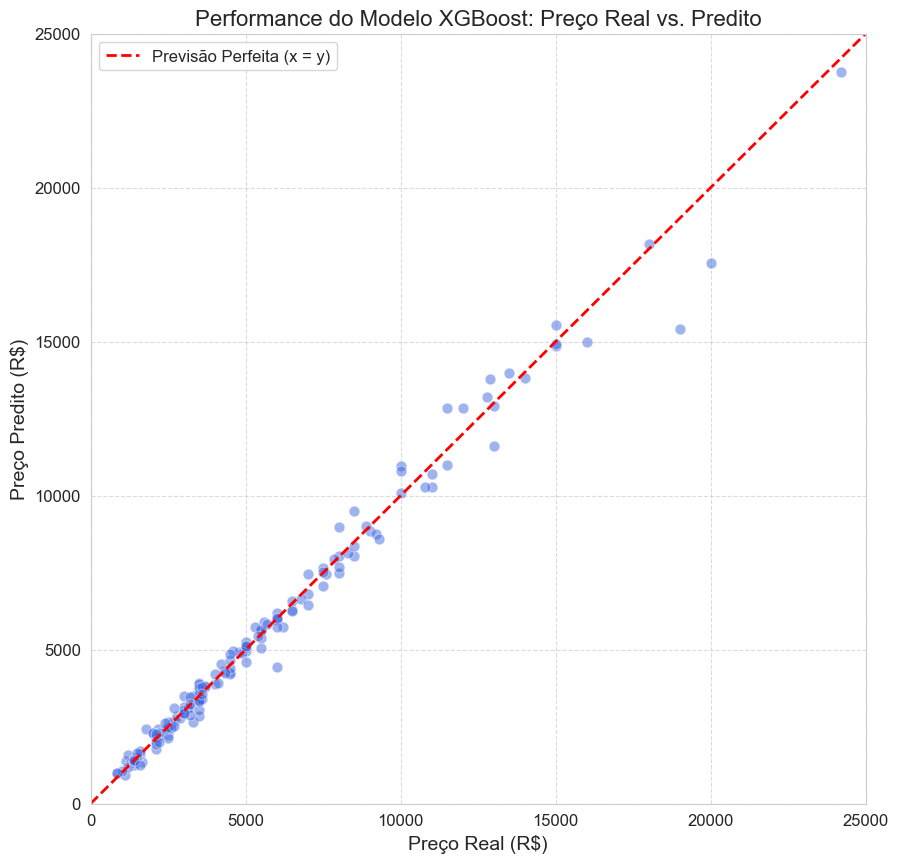

In [23]:
# --- GRÁFICO 4: Real vs. Predito (XGBoost) ---

# Recriar o pipeline final com o melhor modelo
final_pipe = Pipeline([
    ("preprocess", col_transformer),
    ("model", tuned_models['XGBoost'])
])

# Treinar 
final_pipe.fit(X_train, y_train)

# Prever no teste
y_pred_log = final_pipe.predict(X_test)

# Converter de volta para Reais (expm1)
y_real_brl = np.expm1(y_test)
y_pred_brl = np.expm1(y_pred_log)

plt.figure(figsize=(10, 10)) # A figura quadrada garante a proporção visual

# Plot principal
sns.scatterplot(x=y_real_brl, y=y_pred_brl, alpha=0.5, color='royalblue', s=60, edgecolor='w')

# Linha de referência perfeita (Começando do 0 até o limite de 25k)
# Usamos 25000 fixo para a linha ir até o canto do gráfico
plt.plot([0, 25000], [0, 25000], '--', color='red', linewidth=2, label='Previsão Perfeita (x = y)')

plt.title('Performance do Modelo XGBoost: Preço Real vs. Predito', fontsize=16)
plt.xlabel('Preço Real (R$)', fontsize=14)
plt.ylabel('Preço Predito (R$)', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) # Grid ajuda a ver a distorção

plt.xlim(0, 25000)
plt.ylim(0, 25000)

plt.show()

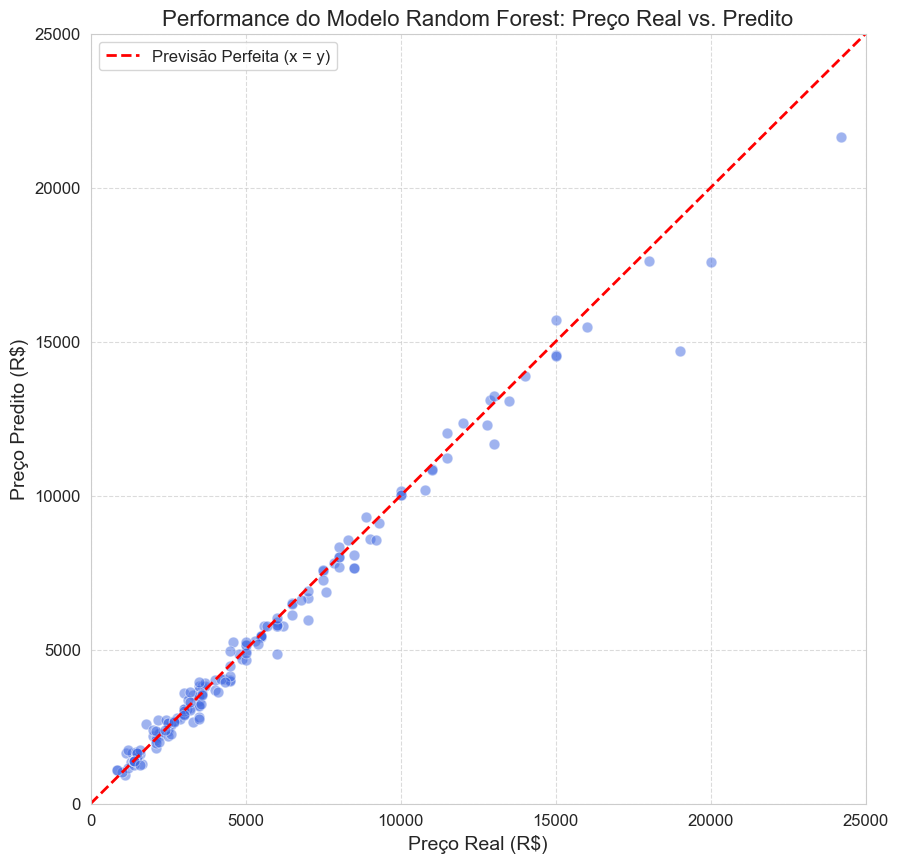

In [24]:
# --- GRÁFICO 5: Real vs. Predito (Random Forest) ---

# Recriar o pipeline final com o modelo Random Forest
final_pipe_rf = Pipeline([
    ("preprocess", col_transformer),
    ("model", tuned_models['RandomForest'])
])

# Treinar 
final_pipe_rf.fit(X_train, y_train)

# Prever no teste
y_pred_log_rf = final_pipe_rf.predict(X_test)

# Converter de volta para Reais (expm1)
y_real_brl = np.expm1(y_test)
y_pred_brl_rf = np.expm1(y_pred_log_rf)

plt.figure(figsize=(10, 10)) # A figura quadrada garante a proporção visual

# Plot principal
sns.scatterplot(x=y_real_brl, y=y_pred_brl_rf, alpha=0.5, color='royalblue', s=60, edgecolor='w')

# Linha de referência perfeita (Começando do 0 até o limite de 25k)
plt.plot([0, 25000], [0, 25000], '--', color='red', linewidth=2, label='Previsão Perfeita (x = y)')

plt.title('Performance do Modelo Random Forest: Preço Real vs. Predito', fontsize=16)
plt.xlabel('Preço Real (R$)', fontsize=14)
plt.ylabel('Preço Predito (R$)', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) 

plt.xlim(0, 25000)
plt.ylim(0, 25000)

plt.show()

# 19) Salvar Modelo que Sera Utilizado

In [25]:
from sklearn.compose import TransformedTargetRegressor

# Esse passo garante que o modelo treine com log, mas devolva a previsão em R$
regressor_com_transformacao = TransformedTargetRegressor(
    regressor=tuned_models['XGBoost'],  # Modelo otimizado
    func=np.log1p,                      # Função para transformar o alvo antes do treino (R$ -> Log)
    inverse_func=np.expm1               # Função para destransformar a previsão (Log -> R$)
)

# Criar o Pipeline Final
pipeline_para_salvar = Pipeline([
    ("preprocessor", col_transformer),
    ("model", regressor_com_transformacao)
])

# 3. Treinar o Pipeline Final
# ATENÇÃO: O TransformedTargetRegressor espera receber o valor original (R$) no fit.
# Como o 'y_train' atual já foi convertido para log anteriormente, usaremos np.expm1(y_train) aqui para reverter ele para R$ apenas para o treinamento.
pipeline_para_salvar.fit(X_train, np.expm1(y_train))

# Salvar o arquivo
joblib.dump(pipeline_para_salvar, 'modelo_locacao.joblib')

print("Modelo salvo com sucesso! O pipeline agora aceita dados brutos e devolve previsões em R$.")

Modelo salvo com sucesso! O pipeline agora aceita dados brutos e devolve previsões em R$.


In [26]:
# EXPORTAÇÃO DE OBJETOS PARA USO NA API

# A API precisa recriar as mesmas features que usamos no treinamento.
# Para isso, ela depende de objetos que foram gerados aqui no notebook:

# media_bairro -> média histórica de preço por bairro
# map_clusters -> dicionário {bairro → cluster}
# kmeans -> modelo KMeans usado para agrupar bairros

# Esses arquivos serão carregados pela API na etapa de pré-processamento, permitindo gerar:
# - preco_medio_bairro
# - dif_media_bairro
# - cluster_bairro

# Sem isso, o modelo não consegue prever, pois faltariam colunas.

# Salva a média do preço dos bairros
joblib.dump(media_bairro, "media_bairro_locacao.joblib")

# Salva o dicionário de clusters por bairro
joblib.dump(map_clusters, "map_clusters_locacao.joblib")

# Salva o modelo KMeans usado nos clusters
joblib.dump(kmeans, "kmeans_bairros_locacao.joblib")

print("Objetos exportados com sucesso.")

Objetos exportados com sucesso.
